# Spam Classification Model Training

This notebook demonstrates the training of a DistilBERT model for spam classification using the real spam-ham dataset.

## Overview
- Load and preprocess spam-ham dataset
- Fine-tune DistilBERT for binary classification
- Evaluate model performance
- Save the trained model using Hugging Face's save_pretrained method

In [1]:
# Import required libraries
import sys
import os
sys.path.append(os.path.join(os.path.dirname('.'), '..', 'scripts'))

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    DistilBertTokenizer, 
    DistilBertForSequenceClassification,
    AdamW,
    get_linear_schedule_with_warmup
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List
import warnings
warnings.filterwarnings('ignore')

# Import training functions from our script
from train_model import (
    SpamDataset, 
    load_or_create_dataset, 
    preprocess_data, 
    train_model, 
    evaluate_model, 
    save_model
)

c:\Users\YEH\anaconda3\envs\myenv\lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
c:\Users\YEH\anaconda3\envs\myenv\lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
c:\Users\YEH\anaconda3\envs\myenv\lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [2]:

def check_gpu_status():
    gpu_available = torch.cuda.is_available()
    gpu_count = torch.cuda.device_count()

    print(f"GPU Available: {gpu_available}")
    print(f"Number of GPUs: {gpu_count}")

    if gpu_available:
        for gpu in range(gpu_count):
            device_name = torch.cuda.get_device_name(gpu)
            total_memory = torch.cuda.get_device_properties(gpu).total_memory / (1024 ** 3)  # Convert bytes to GB
            reserved_memory = torch.cuda.memory_reserved(gpu) / (1024 ** 3)
            allocated_memory = torch.cuda.memory_allocated(gpu) / (1024 ** 3)
            free_memory = reserved_memory - allocated_memory

            print(f"\nGPU {gpu}: {device_name}")
            print(f"  Total Memory: {total_memory:.2f} GB")
            print(f"  Reserved Memory: {reserved_memory:.2f} GB")
            print(f"  Allocated Memory: {allocated_memory:.2f} GB")
            print(f"  Free Memory: {free_memory:.2f} GB")

if __name__ == "__main__":
    check_gpu_status()

GPU Available: True
Number of GPUs: 1

GPU 0: NVIDIA GeForce RTX 3060 Laptop GPU
  Total Memory: 6.00 GB
  Reserved Memory: 0.00 GB
  Allocated Memory: 0.00 GB
  Free Memory: 0.00 GB


## 1. Data Loading and Exploration

In [3]:
# Load the real spam-ham dataset
df = load_or_create_dataset()
print(f"Dataset shape: {df.shape}")
print(f"\nClass distribution:")
print(df['label'].value_counts())

# Display sample data
print(f"\nSample data:")
print(df.head(10))

2025-07-04 21:29:36,845 - INFO - Loading spam-ham dataset from data/spam_ham_dataset.csv ...
2025-07-04 21:29:36,909 - INFO - Loaded dataset with 5171 samples. Class distribution:
label
ham     3672
spam    1499
Name: count, dtype: int64


Dataset shape: (5171, 2)

Class distribution:
label
ham     3672
spam    1499
Name: count, dtype: int64

Sample data:
                                                text label
0  Subject: enron methanol ; meter # : 988291\r\n...   ham
1  Subject: hpl nom for january 9 , 2001\r\n( see...   ham
2  Subject: neon retreat\r\nho ho ho , we ' re ar...   ham
3  Subject: photoshop , windows , office . cheap ...  spam
4  Subject: re : indian springs\r\nthis deal is t...   ham
5  Subject: ehronline web address change\r\nthis ...   ham
6  Subject: spring savings certificate - take 30 ...   ham
7  Subject: looking for medication ? we ` re the ...  spam
8  Subject: noms / actual flow for 2 / 26\r\nwe a...   ham
9  Subject: nominations for oct . 21 - 23 , 2000\...   ham


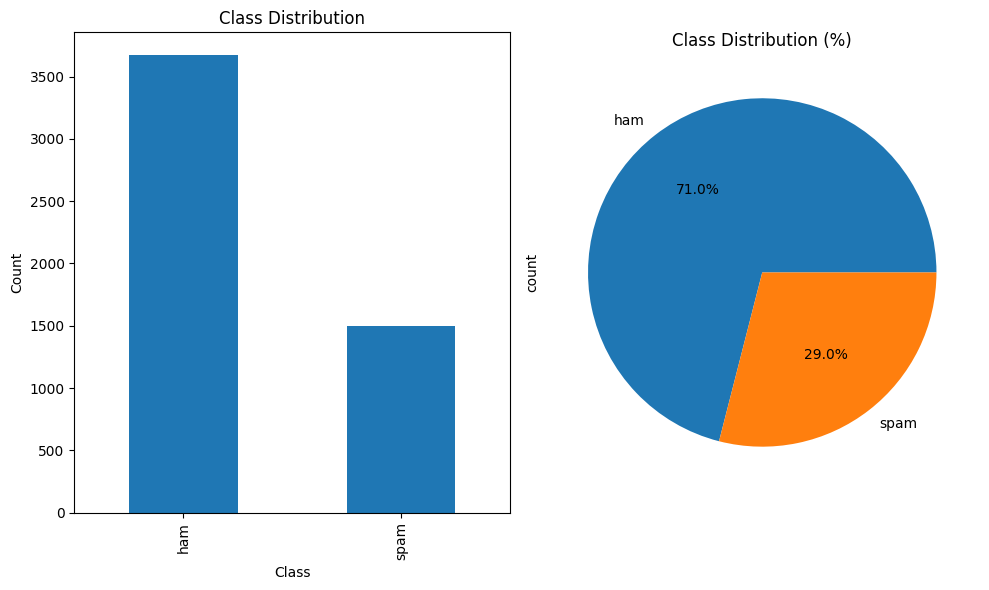

In [4]:
# Visualize class distribution
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
df['label'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Class Distribution (%)')

plt.tight_layout()
plt.show()

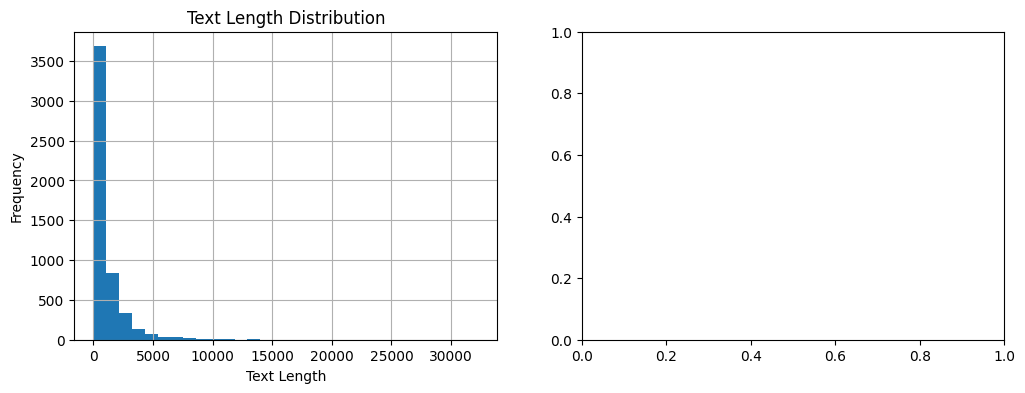

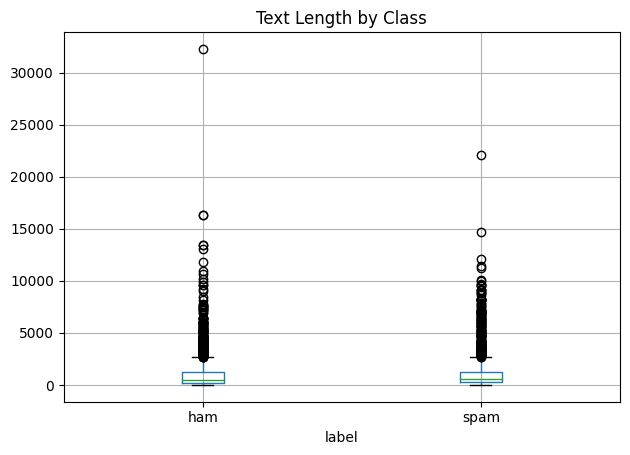

Text length statistics:
count     5171.000000
mean      1048.391994
std       1528.513435
min         11.000000
25%        244.000000
50%        540.000000
75%       1237.000000
max      32258.000000
Name: text_length, dtype: float64


In [5]:
# Analyze text length distribution
df['text_length'] = df['text'].str.len()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
df['text_length'].hist(bins=30)
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
df.boxplot(column='text_length', by='label')
plt.title('Text Length by Class')
plt.suptitle('')

plt.tight_layout()
plt.show()

print(f"Text length statistics:")
print(df['text_length'].describe())

## 2. Data Preprocessing

In [6]:
# Preprocess data
texts, labels, label_encoder = preprocess_data(df)

print(f"Label mapping: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")
print(f"Number of texts: {len(texts)}")
print(f"Number of labels: {len(labels)}")

2025-07-04 21:29:37,812 - INFO - Preprocessing data...
2025-07-04 21:29:37,819 - INFO - Label mapping: {'ham': 0, 'spam': 1}


Label mapping: {'ham': 0, 'spam': 1}
Number of texts: 5171
Number of labels: 5171


In [7]:
# Split data into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Training samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")
print(f"\nTraining class distribution:")
print(pd.Series(train_labels).value_counts())
print(f"\nValidation class distribution:")
print(pd.Series(val_labels).value_counts())

Training samples: 4136
Validation samples: 1035

Training class distribution:
0    2937
1    1199
Name: count, dtype: int64

Validation class distribution:
0    735
1    300
Name: count, dtype: int64


## 3. Model Setup

In [8]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize tokenizer and model
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_encoder.classes_)
)
model.to(device)

print(f"Model initialized with {len(label_encoder.classes_)} classes")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Using device: cuda


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model initialized with 2 classes
Model parameters: 66,955,010


In [9]:
# Create datasets and data loaders
train_dataset = SpamDataset(train_texts, train_labels, tokenizer)
val_dataset = SpamDataset(val_texts, val_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Training batches: 259
Validation batches: 65


## 4. Model Training

In [10]:
# Train the model
predictions, true_labels = train_model(model, train_loader, val_loader, device, num_epochs=5)

2025-07-04 21:29:40,513 - INFO - Starting model training...
2025-07-04 21:29:41,924 - INFO - Epoch 1/5
2025-07-04 21:30:23,429 - INFO - Average training loss: 0.1429
2025-07-04 21:30:30,408 - INFO - Validation Loss: 0.0504
2025-07-04 21:30:30,409 - INFO - Validation Accuracy: 0.9807
2025-07-04 21:30:30,410 - INFO - New best accuracy: 0.9807
2025-07-04 21:30:30,410 - INFO - Epoch 2/5
2025-07-04 21:31:06,712 - INFO - Average training loss: 0.0233
2025-07-04 21:31:13,791 - INFO - Validation Loss: 0.0183
2025-07-04 21:31:13,793 - INFO - Validation Accuracy: 0.9932
2025-07-04 21:31:13,794 - INFO - New best accuracy: 0.9932
2025-07-04 21:31:13,795 - INFO - Epoch 3/5
2025-07-04 21:31:50,399 - INFO - Average training loss: 0.0069
2025-07-04 21:31:57,569 - INFO - Validation Loss: 0.0101
2025-07-04 21:31:57,570 - INFO - Validation Accuracy: 0.9932
2025-07-04 21:31:57,571 - INFO - Epoch 4/5
2025-07-04 21:32:33,950 - INFO - Average training loss: 0.0011
2025-07-04 21:32:40,975 - INFO - Validation 

## 5. Model Evaluation

In [11]:
# Evaluate model performance
evaluate_model(predictions, true_labels, label_encoder)

2025-07-04 21:33:39,225 - INFO - Evaluating model...



Classification Report:
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       735
        spam       1.00      0.97      0.98       300

    accuracy                           0.99      1035
   macro avg       0.99      0.98      0.99      1035
weighted avg       0.99      0.99      0.99      1035


Confusion Matrix:
[[735   0]
 [  9 291]]

Overall Accuracy: 0.9913


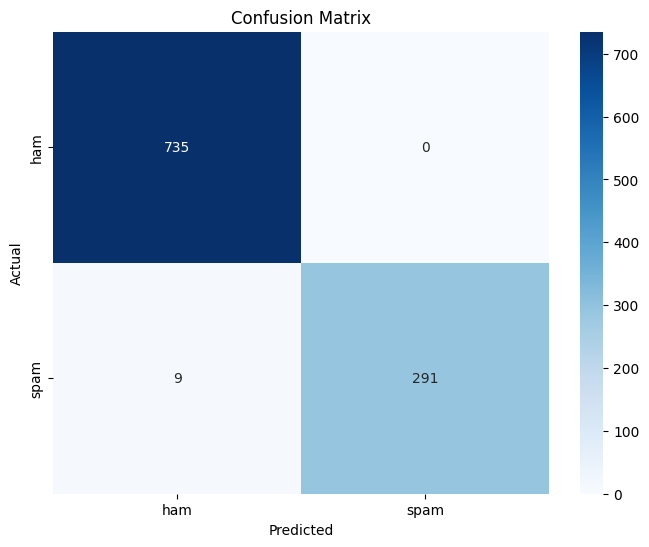

In [12]:
# Create confusion matrix visualization
pred_labels = label_encoder.inverse_transform(predictions)
true_labels_decoded = label_encoder.inverse_transform(true_labels)

cm = confusion_matrix(true_labels_decoded, pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 6. Model Testing

In [13]:
# Test the model with sample texts
test_texts = [
    "Hi Tom, how are you doing?",
    "URGENT! You have won a 1 week FREE membership in our £100,000 prize Jackpot!",
    "I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k?",
    "URGENT! Your Mobile No. was awarded £200 Bonus Caller Prize on 1/08.",
    "I HAVE A DATE ON SUNDAY WITH WILL!!"
]

model.eval()
with torch.no_grad():
    for text in test_texts:
        inputs = tokenizer(
            text,
            truncation=True,
            padding=True,
            max_length=512,
            return_tensors="pt"
        ).to(device)
        
        outputs = model(**inputs)
        probabilities = torch.softmax(outputs.logits, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][predicted_class].item()
        
        prediction = label_encoder.inverse_transform([predicted_class])[0]
        
        print(f"Text: {text[:50]}...")
        print(f"Prediction: {prediction}")
        print(f"Confidence: {confidence:.4f}")
        print("-" * 50)

Text: Hi Tom, how are you doing?...
Prediction: ham
Confidence: 0.7471
--------------------------------------------------
Text: URGENT! You have won a 1 week FREE membership in o...
Prediction: spam
Confidence: 0.9996
--------------------------------------------------
Text: I'm gonna be home soon and i don't want to talk ab...
Prediction: ham
Confidence: 0.9911
--------------------------------------------------
Text: URGENT! Your Mobile No. was awarded £200 Bonus Cal...
Prediction: spam
Confidence: 0.9994
--------------------------------------------------
Text: I HAVE A DATE ON SUNDAY WITH WILL!!...
Prediction: ham
Confidence: 0.8712
--------------------------------------------------


## 7. Save Model

In [14]:
# Save the trained model using Hugging Face's save_pretrained method
model_path = os.path.join(os.path.dirname('.'), '..', 'models', 'spam_classifier')
save_model(model, tokenizer, label_encoder, model_path)

print(f"Model saved to: {model_path}")
print("Model saved in Hugging Face format with the following files:")
print("- config.json (model configuration)")
print("- pytorch_model.bin (model weights)")
print("- tokenizer.json (tokenizer configuration)")
print("- vocab.txt (vocabulary file)")
print("- label_encoder.pkl (label encoder)")

2025-07-04 21:34:00,217 - INFO - Saving model to ..\models\spam_classifier
2025-07-04 21:34:00,798 - INFO - Model saved successfully using Hugging Face's save_pretrained method!


Model saved to: ..\models\spam_classifier
Model saved in Hugging Face format with the following files:
- config.json (model configuration)
- pytorch_model.bin (model weights)
- tokenizer.json (tokenizer configuration)
- vocab.txt (vocabulary file)
- label_encoder.pkl (label encoder)


## 8. Model Loading Test

In [15]:
# Test loading the saved model using Hugging Face's from_pretrained method
loaded_model = DistilBertForSequenceClassification.from_pretrained(model_path)
loaded_tokenizer = DistilBertTokenizer.from_pretrained(model_path)
loaded_label_encoder = joblib.load(os.path.join(model_path, 'label_encoder.pkl'))

print("Model loaded successfully using Hugging Face's from_pretrained method!")
print(f"Model type: {type(loaded_model)}")
print(f"Tokenizer type: {type(loaded_tokenizer)}")
print(f"Label encoder classes: {loaded_label_encoder.classes_}")

# Test prediction with loaded model
test_text = "URGENT! You have won a prize!"
inputs = loaded_tokenizer(
    test_text,
    truncation=True,
    padding=True,
    max_length=512,
    return_tensors="pt"
)

loaded_model.eval()
with torch.no_grad():
    outputs = loaded_model(**inputs)
    probabilities = torch.softmax(outputs.logits, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()
    confidence = probabilities[0][predicted_class].item()
    prediction = loaded_label_encoder.inverse_transform([predicted_class])[0]
    
    print(f"\nTest prediction with loaded model:")
    print(f"Text: {test_text}")
    print(f"Prediction: {prediction}")
    print(f"Confidence: {confidence:.4f}")

Model loaded successfully using Hugging Face's from_pretrained method!
Model type: <class 'transformers.models.distilbert.modeling_distilbert.DistilBertForSequenceClassification'>
Tokenizer type: <class 'transformers.models.distilbert.tokenization_distilbert.DistilBertTokenizer'>
Label encoder classes: ['ham' 'spam']

Test prediction with loaded model:
Text: URGENT! You have won a prize!
Prediction: spam
Confidence: 0.9988


## 9. Model Directory Structure

In [16]:
# Display the model directory structure
import os
from pathlib import Path

model_dir = Path(model_path)
if model_dir.exists():
    print("Model directory structure:")
    for file_path in model_dir.rglob('*'):
        if file_path.is_file():
            relative_path = file_path.relative_to(model_dir)
            file_size = file_path.stat().st_size
            print(f"  {relative_path} ({file_size:,} bytes)")
else:
    print("Model directory not found. Please run the training first.")

Model directory structure:
  config.json (640 bytes)
  label_encoder.pkl (539 bytes)
  model.safetensors (267,832,560 bytes)
  special_tokens_map.json (132 bytes)
  tokenizer_config.json (1,305 bytes)
  vocab.txt (262,030 bytes)
